In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

import os
import shutil
from glob import glob
from PIL import Image
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

2025-06-08 18:30:50.897837: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
skin_df = pd.read_csv("metadata_processed.csv", index_col=0)
skin_df

lesion_id      image_id     dx       age  sex_female  sex_male  \
4163   HAM_0003697  ISIC_0025438     nv  0.470588       False      True   
8687   HAM_0000217  ISIC_0029881     nv  0.470588       False      True   
3221   HAM_0003344  ISIC_0026399     nv  0.411765        True     False   
8752   HAM_0006028  ISIC_0032189     nv  0.470588       False      True   
5811   HAM_0000162  ISIC_0026609     nv  0.470588        True     False   
...            ...           ...    ...       ...         ...       ...   
10010  HAM_0002867  ISIC_0033084  akiec  0.470588       False      True   
10011  HAM_0002867  ISIC_0033550  akiec  0.470588       False      True   
10012  HAM_0002867  ISIC_0033536  akiec  0.470588       False      True   
10013  HAM_0000239  ISIC_0032854  akiec  0.941176       False      True   
10014  HAM_0003521  ISIC_0032258    mel  0.823529        True     False   

       sex_unknown  localization_abdomen  localization_back  \
4163         False                 False               True   
8687         False                 False              False   
3221         False                  True              False   
8752         False                 False              False   
5811         False                 False               True   
...            ...                   ...                ...   
10010        False                  True              False   
10011        False                  True              False   
10012        False                  True              False   
10013        False                 False              False   
10014        False                 False               True   

       localization_chest  ...  localization_neck  localization_scalp  \
4163                False  ...              False               False   
8687                 True  ...              False               False   
3221                False  ...              False               False   
8752                 True  ...              False               False   
5811                False  ...              False               False   
...                   ...  ...                ...                 ...   
10010               False  ...              False               False   
10011               False  ...              False               False   
10012               False  ...              False               False   
10013               False  ...              False               False   
10014               False  ...              False               False   

       localization_trunk  localization_unknown  localization_upper extremity  \
4163                False                 False                         False   
8687                False                 False                         False   
3221                False                 False                         False   
8752                False                 False                         False   
5811                False                 False                         False   
...                   ...                   ...                           ...   
10010               False                 False                         False   
10011               False                 False                         False   
10012               False                 False                         False   
10013               False                 False                         False   
10014               False                 False                         False   

       dx_type_confocal  dx_type_consensus  dx_type_follow_up  dx_type_histo  \
4163              False              False               True          False   
8687              False              False              False           True   
3221              False              False               True          False   
8752              False              False              False           True   
5811              False              False               True          False   
...                 .

In [5]:
# dictionary for mapping lesion types
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Bowens disease',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [7]:
# map labels to their full names (for visualizing) and create encoded labels
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [9]:
skin_df['cell_type'].unique()

array(['Melanocytic nevi', 'Benign keratosis-like lesions',
       'Dermatofibroma', 'Melanoma', 'Vascular lesions',
       'Basal cell carcinoma', 'Bowens disease'], dtype=object)

In [11]:
print(skin_df.dtypes)

lesion_id                        object
image_id                         object
dx                               object
age                             float64
sex_female                         bool
sex_male                           bool
sex_unknown                        bool
localization_abdomen               bool
localization_back                  bool
localization_chest                 bool
localization_ear                   bool
localization_face                  bool
localization_foot                  bool
localization_genital               bool
localization_hand                  bool
localization_lower extremity       bool
localization_neck                  bool
localization_scalp                 bool
localization_trunk                 bool
localization_unknown               bool
localization_upper extremity       bool
dx_type_confocal                   bool
dx_type_consensus                  bool
dx_type_follow_up                  bool
dx_type_histo                      bool


In [13]:
# load and resize images
def load_and_resize_image(path, target_size=(224, 224)):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = image / 255.0
    return np.asarray(image)

In [15]:
# # apply the preprocessing function to the image paths
# skin_df['image'] = skin_df['image_path'].map(lambda x: load_and_resize_image(x))

In [17]:
# # save the preprocessed images (dont need to wait every time)
# np.save('resized_images.npy', np.stack(skin_df['image'].values))

In [21]:
# if transformed images were saved as .np file beforehand load as such:
image = np.load('resized_images.npy') 

In [31]:
print(image.shape)
print(skin_df.shape[0]) #row number should match images.shape[0]

(4423, 224, 224, 3)
4423


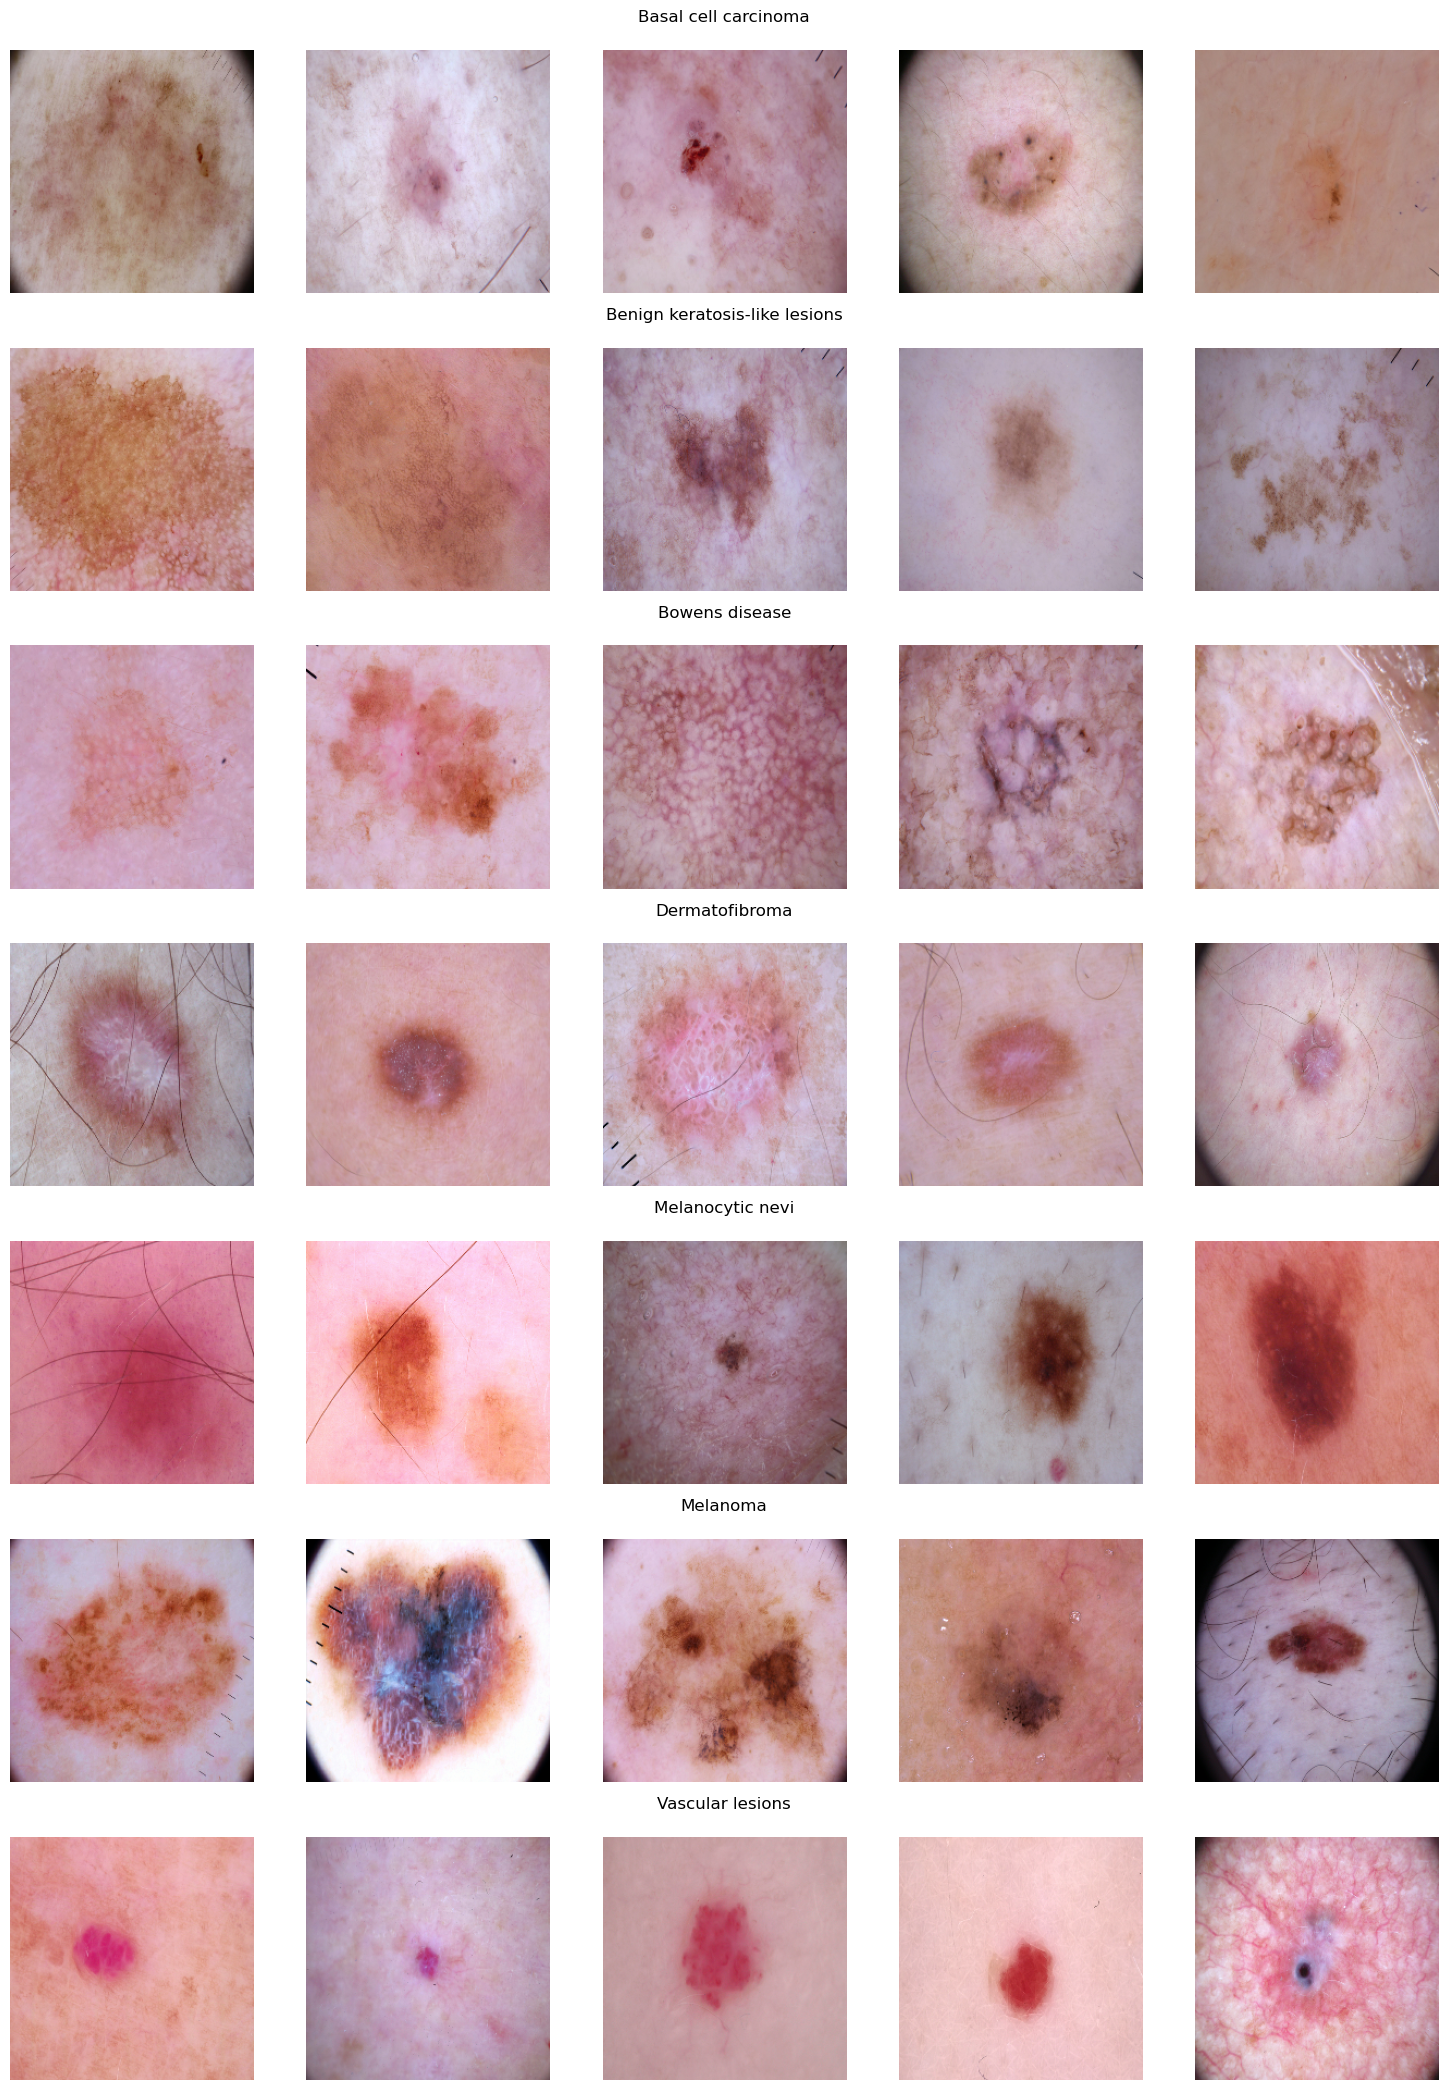

In [33]:
# visualize sample images per class
# make sure DataFrame index matches images
skin_df = skin_df.reset_index(drop=True)

n_samples = 5
unique_classes = sorted(skin_df['cell_type'].unique())
num_classes = len(unique_classes)

fig, axs = plt.subplots(num_classes, n_samples, figsize=(3 * n_samples, 3 * num_classes))

for i, cell_type in enumerate(unique_classes):
    class_rows = skin_df[skin_df['cell_type'] == cell_type].sample(n_samples, random_state=42)
    for j, idx in enumerate(class_rows.index):
        axs[i, j].imshow(image[idx])
        axs[i, j].axis('off')

    # Add centered title above the row
    mid_col = n_samples // 2
    axs[i, mid_col].set_title(cell_type, fontsize=12, pad=20)

plt.tight_layout()
plt.show()


In [43]:
# split features and target
features = skin_df.drop(['cell_type_idx'], axis=1)
target = skin_df['cell_type_idx']

In [45]:
# split into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(features, target, stratify=target, test_size=0.15, random_state=13)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.15, random_state=13)


In [ ]:
# #convert transformed images to np.array (the images were not loaded as .np file)
# X_train = np.asarray(x_train['image'].tolist())
# X_val = np.asarray(x_val['image'].tolist())
# X_test = np.asarray(x_test['image'].tolist())

In [47]:
# split into train, validation, and test sets (if the images were loeaded as .np file)
X_train = image[x_train.index]
X_val = image[x_val.index]
X_test = image[x_test.index]

In [93]:
X_test.shape

(664, 224, 224, 3)

In [115]:
y_train_onehot = to_categorical(y_train, num_classes=7)
y_val_onehot = to_categorical(y_val, num_classes=7)
y_test_onehot = to_categorical(y_test, num_classes=7)

In [101]:
# ImageDataGenerator with augmentation options
datagen = ImageDataGenerator(
    rotation_range=45,         # rotates images by up to 45 degrees
    width_shift_range=0.2,     # shift images horizontally by up to 20%
    height_shift_range=0.2,    # shift images vertically by up to 20%
    zoom_range=0.2,            # zoom images by up to 20%
    horizontal_flip=True,      # randomly flip images horizontally
    brightness_range=[0.8,1.2],# random brightness adjustment
    fill_mode='nearest'        # fill any missing pixels after transformation
)

datagen.fit(X_train)

In [65]:
def sequential_model(input_shape=(224, 224, 3), num_classes=7):
    # EfficientNetB0 without the top classification layer, to be able to modify the number of classes
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    # uses pretrained weights for feature extraction
    

    base_model.trainable = False # freezes all layers of EfficientNetB0 so they would not update during training
    #because the data is limited

    model = Sequential([
        InputLayer(input_shape=input_shape),
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'), # ReLU activation for complex patterns
        Dropout(0.25), # dropout(0.25) to prevent overfitting
        Dense(256, activation='relu'),
        Dropout(0.25),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dropout(0.25),
        Dense(num_classes, activation='softmax') # probability distribution over 7 classes
    ])

    return model

model = sequential_model(input_shape=(224, 224, 3), num_classes=7)


/Library/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [67]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,484,906 (17.11 MB)

 Trainable params: 435,335 (1.66 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [107]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy', #for multilable classification
    metrics=['accuracy', AUC()]
)

In [111]:
batch_size = 32 # the model processes 32 images at a time before updating weights
epochs = 15

train_generator = datagen.flow(X_train, y_train_onehot, batch_size=batch_size)

# validation data is not augmented
val_generator = datagen.flow(X_val, y_val_onehot, batch_size=batch_size, shuffle=False)

history = model.fit(
    train_generator,                
    epochs=epochs,
    validation_data=val_generator,
    verbose=1)


/Library/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.2420 - auc_5: 0.6998 - loss: 1.7504 - val_accuracy: 0.2518 - val_auc_5: 0.7138 - val_loss: 1.7062
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.2484 - auc_5: 0.7111 - loss: 1.7183 - val_accuracy: 0.2518 - val_auc_5: 0.7148 - val_loss: 1.7007
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.2475 - auc_5: 0.7131 - loss: 1.7090 - val_accuracy: 0.2482 - val_auc_5: 0.7137 - val_loss: 1.7041
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.2418 - auc_5: 0.7087 - loss: 1.7148 - val_accuracy: 0.2518 - val_auc_5: 0.7148 - val_loss: 1.7042
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.2432 - auc_5: 0.7068 - loss: 1.7151 - val_accuracy: 0.2518 - val_auc_5: 0.7148 - val_loss: 1.6921
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.2549 - auc_5: 0.7123 - loss: 1.7126 - val_accuracy: 0.2518 - val_auc_5: 0.7142 - val_loss: 1.6972
Epoch 7/15

In [137]:
#model evaluation on the test set
loss, accuracy_test, auc_test= model.evaluate(X_test, y_test_onehot, verbose=1)

#model evaluation on the validation set
loss_v, accuracy_val, auc_val = model.evaluate(X_val, y_val_onehot, verbose=1)

print("Validation: AUC = %f  ;  Loss = %f; Accuracy = %f" % (auc_val, loss_v, accuracy_val))
print("Test: AUC = %f  ;  Loss = %f ;  Accuracy = %f" % (auc_test, loss, accuracy_test))


# save the model for multimodel classification
model.save("cnn_model.h5")

21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.2471 - auc_5: 0.7103 - loss: 1.6939
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.2455 - auc_5: 0.7235 - loss: 1.6708


Validation: AUC = 0.714835  ;  Loss = 1.689542; Accuracy = 0.251773
Test: AUC = 0.714859  ;  Loss = 1.689528 ;  Accuracy = 0.251506


In [139]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1, len(model_history.history['accuracy']) // 10))
    axs[0].legend(['train', 'val'], loc='best')
    
    # history for loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1, len(model_history.history['loss']) // 10))
    axs[1].legend(['train', 'val'], loc='best')
    
    plt.show()

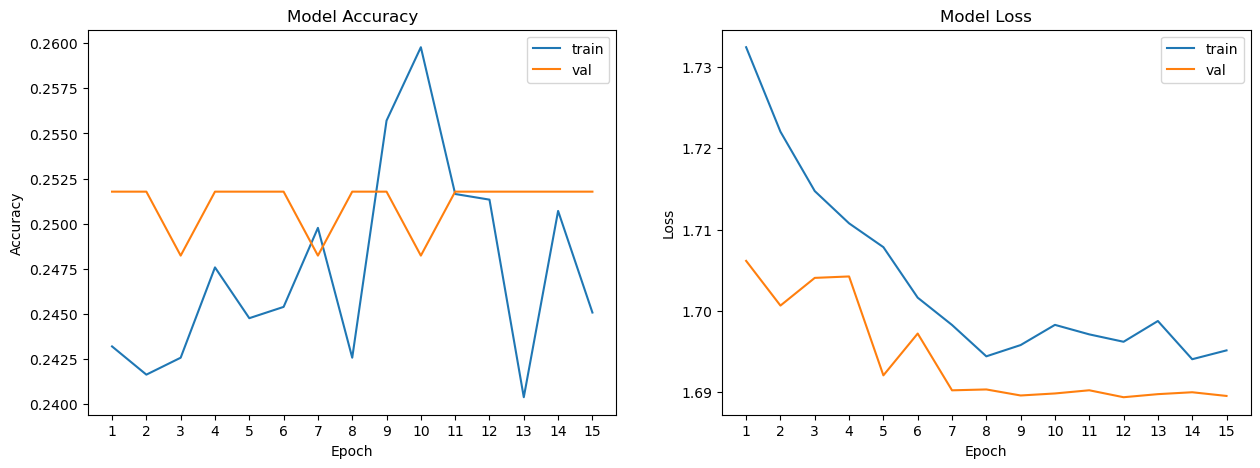

In [141]:
plot_model_history(history)

In [143]:
#plot confusion matrix    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step


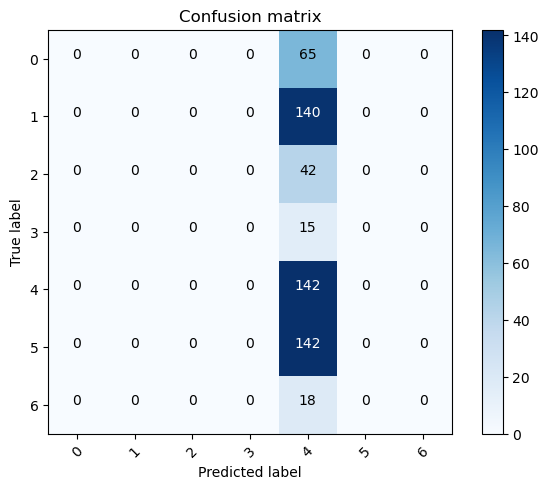

In [145]:
# predict the values from the validation dataset
y_pred = model.predict(X_val)
# convert predictions and validation classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = np.argmax(y_val_onehot,axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 